# GLCM Experiment 
-- The main goal is extract features of an image and compare results with area of determined mask by especialist

--Libraries:

In [1]:
#update numpy to 1.14.1
#only to azure jupyter notebook
#import sys
#!{sys.executable} -m conda install numpy -y

In [2]:
#%matplotlib notebook

from skimage import feature
from skimage import io
import skimage
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from enum import Enum
import numpy
import numpy as np

In [3]:
numpy.version.version
#need '1.14.2' or upper

'1.14.2'

In [4]:
def splitIMG(numTiles, imgPath):
    numTiles = 4 if (numTiles < 0) else numTiles
    p_img = Image.open(imgPath)
    result = []
    rectangles = []
    
    cr = math.sqrt(numTiles)
    width = int(p_img.width / cr)
    height = int(p_img.height / cr)

    start_x = 0
    start_y = 0
    final_x = width
    final_y = height

    curr_column = 1
    curr_row = 1

    rect = (start_x, start_y, final_x, final_y)
    diffW = int(p_img.width - (width * cr))
    diffH = int(p_img.height - (height * cr))

    for i in range(numTiles):
        #first row
        if(curr_row == 1):
            #first column of first row
            if(curr_column == 1):
                curr_column = curr_column + 1
            #between first and last column of first row
            elif(curr_column > 1 and curr_column < cr*curr_row):
                rect = (rect[0]+width, rect[1], rect[2]+width, rect[3])
                curr_column = curr_column + 1
            #last column of first row
            elif(curr_column == cr*curr_row):
                rect = (rect[0]+width, rect[1], rect[2]+width+diffW, rect[3])
                curr_column = curr_column + 1
                curr_row = curr_row + 1
        #between first row and last row
        elif(curr_row > 1 and curr_row < cr):
            #first column of between first row and last row
            if(curr_column == (((curr_row-1) * cr)+1)):
                curr_column = curr_column + 1
                rect = (0, rect[1]+height, width, rect[3]+height)
            #between first and last column of between first row and last row
            elif(curr_column > 1 and curr_column < cr*curr_row):
                rect = (rect[0]+width, rect[1], rect[2]+width, rect[3])
                curr_column = curr_column + 1
            #last column of between first row and last row
            elif(curr_column == cr*curr_row):
                rect = (rect[0]+width, rect[1], rect[2]+width+diffW, rect[3])
                curr_column = curr_column + 1
                curr_row = curr_row + 1
        #last row
        elif(curr_row == cr):
            #first column of last row
            if(curr_column == (((curr_row-1) * cr)+1)):
                curr_column = curr_column + 1
                rect = (0, rect[1]+height+diffH, width, rect[3]+height+diffH)
            #between first and last column of last row
            elif(curr_column > 1 and curr_column < cr*curr_row):
                rect = (rect[0]+width, rect[1], rect[2]+width, rect[3])
                curr_column = curr_column + 1
            #last column of last row
            elif(curr_column == cr*curr_row):
                rect = (rect[0]+width, rect[1], rect[2]+width+diffW, rect[3])
                curr_column = curr_column + 1
                curr_row = curr_row + 1

        #print(rect)
        rectangles.append(rect)
        clone = p_img.crop(rect)
        result.append(clone)
        
    return result, rect

In [5]:
def splitIMGbySize(width, height, imgPath):

    img = Image.open(imgPath)
    result = []
    rectangles = []

    diff_columns = img.width - (int(img.width / width) * width)
    diff_rows = img.height - (int(img.height / height) * height)

    start_x = 0
    start_y = 0
    final_x = width
    final_y = height
    rect = (start_x, start_y, final_x, final_y)

    while (start_y < img.height) :
        

        final_x = 0
        while (final_x < img.width) :

            #if last column gets the image width
            if((final_x + width) > img.width):
                final_x = img.width
            else:
                final_x += width
            
            start_x = 0 if final_x-width == 0 else rect[2]
            rect = (start_x, start_y, final_x, final_y)
            #print(rect)
            rectangles.append(rect)
            clone = img.crop(rect)
            result.append(clone)
        
        #if last row gets the image height
        if((start_y + height) > img.height):
            start_y += height
            final_y = img.height
        else:
            start_y += height
            if(final_y + height >= img.height):
                final_y = img.height
            else:
                final_y += height
    return result, rectangles

In [6]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    """
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(facecolor='white')
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        #a = a.axis('off')
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [7]:
class imageTiles(Enum):
    part1 = 1, '1'
    part4 = 4, '4'
    part16 = 16, '16'
    part64 = 64, '64'
    part256 = 256, '256'
    part1024 = 1024, '1024'
    part4096 = 4096, '4096'
    part16384 = 16384, '16384' 

    def __init__(self, value, name):
        self._value_ = value
        self.fullname = name

In [8]:
class imageProperties():
    img = None, False, -1, None, None, None, None, None, None, None

    def __init__(self, image, mask, pos, _contrast, _dissimilarity, _homogeneity, _ASM, _energy, _descriptors, _entropy, _rectangle):
        self.value = image
        self.isMask = mask
        self.position = pos
        self.contrast = _contrast
        self.dissimilarity = _dissimilarity
        self.homogeneity = _homogeneity
        self.ASM = _ASM
        self.energy = _energy
        self.descriptors = _descriptors
        self.entropy = _entropy
        self.rectangle = _rectangle

In [9]:
def PCA(X, new_dim, use_cov=False):
    """
    IN:
    X: [N,M] array, where N is the number of objects and M the number of features
    new_dim: Dimension of the projected data (number of PCA features)
    useCov: Whether to use covariance matrix (True) or correlation matrix (False)

    OUT:
    PCA_features: [N,new_dim] array, new features
    eigenvalues: Eigenvalues in decreasing order
    main_eigenvectors: [N,new_dim] array, Eigenvectors in each column
    """
    
    # Use covariance matrix or correlation matrix
    if use_cov:
        C = np.cov(X.T)
    else:
        C = np.corrcoef(X.T)

    # Obtain the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(C)

    # Get indices that will be used to sort the eigenvalues in decreasing order
    sorted_indices = np.argsort(eigenvalues)[::-1]

    # Sort the eigenvalues and respective eigenvectors
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:,sorted_indices]

    # Keep only the L first eigenvectors
    main_eigenvectors = eigenvectors[:,0:new_dim]  

    # Subtract the mean of each feature
    u = np.mean(X,axis=0)
    X_norm = X-u

    # Also divide by the standard deviation
    if (use_cov==False):
        stdev = np.std(X, axis=0, ddof=1)
        X_norm = X_norm/stdev
    
    # Project the data into new variables (PCA features)
    PCA_features = np.dot(X_norm, main_eigenvectors)
    
    return PCA_features, eigenvalues, main_eigenvectors

-- GLCM parameters:

In [10]:
#imgPath = 'img-experiment/img-window-green-channel20.jpg'
#maskPath = 'img-experiment/mask20.jpg'

#imgPath = 'img-experiment/tijarvore.jpg'
#maskPath = 'img-experiment/PERFECT_MASK_tijarvore.jpg'
#maskPath = 'img-experiment/APROXIMATED_MASK_tijarvore.jpg'

#imgPath = 'img-experiment/S07_46186_lower_10X_Snapshot_20151028_59.jpg'
#imgPath = 'img-experiment/S07_46186_lower_10X_Snapshot_20151028_59_gray.jpg'
#maskPath = 'img-experiment/MASK_S07_46186_lower_10X_Snapshot_20151028_59.jpg'

#imgPath = 'img-experiment/S07_46186_lower_10X_Snapshot_20151028_59_tile.jpg'
#maskPath = 'img-experiment/MASK_S07_46186_lower_10X_Snapshot_20151028_59_tile.jpg'

#imgPath = 'img-experiment/S07_40805_lower_10X_Snapshot_20151028_55.jpg'
#maskPath = 'img-experiment/MASK_S07_40805_lower_10X_Snapshot_20151028_55.jpg'

imgPath = 'img-experiment/ORIGINAL_S07_46186_lower_10X_Snapshot_20151028_59.jpg'
#imgPath = 'img-experiment/orange_gray.jpg'
#maskPath = 'img-experiment/mask_orange.jpg'
maskPath = 'img-experiment/MASK_ORIGINAL_S07_46186_lower_10X_Snapshot_20151028_59.jpg'
#maskPath = 'img-experiment/MASK_2_ORIGINAL_S07_46186_lower_10X_Snapshot_20151028_59.jpg'

#imgPath = 'img-experiment/img_rod.jpg'
#maskPath = 'img-experiment/mask_img_rod.jpg'


#imgPath = 'img-experiment/partial_original_300dpi_autolevels.jpg'
#maskPath = 'img-experiment/MASK_mid.jpg'



image = skimage.io.imread(imgPath)
mask = skimage.io.imread(maskPath)

distances = [2]
levels = image.max()+1 #optional
descriptorsQuantity = 6
fixedDegrees = [0, numpy.pi/4, numpy.pi/2, 3*numpy.pi/4]

# ---- size by imageTiles ----
# if pixels != 0 use by pixels else use by imageTiles
#tiles = imageTiles.part4096.value
#tiles = imageTiles.part1024.value
tiles = imageTiles.part256.value
#tiles = imageTiles.part64.value
#tiles = imageTiles.part16.value
# ---- OR by pixels ----
# if pixels != 0 use by pixels else use by imageTiles
#tileWidth = 4
#tileHeight = 3
tileWidth = 200
tileHeight = 200
# -- --

resultPathTiles = 'GLCM-results/' + str(imgPath.split('/')[1].split('.')[0])[0:100] + '_' + str(tileWidth) + 'w_' + str(tileHeight) + 'h_' + str(distances[0]) + 'd_' + 'A_ImgMsk' + '.png'
resultPathHistogram = 'GLCM-results/' + str(imgPath.split('/')[1].split('.')[0])[0:100] + '_' + str(tileWidth) + 'w_' + str(tileHeight) + 'h_'+ str(distances[0]) + 'd_' + 'B_Hist' + '.png'
resultPathPCA = 'GLCM-results/' + str(imgPath.split('/')[1].split('.')[0])[0:100] + '_' +  str(tileWidth) + 'w_' + str(tileHeight) + 'h_'+ str(distances[0]) + 'd_' + 'C_PCA' + '.png'


insideMask = 70
insideMaskBorder = 5
printMaskImg = False



Degrees = [0, 45.0, 90.0, 135.0]
Distances: [2]
Levels: 256


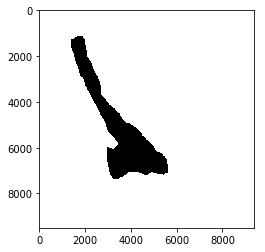

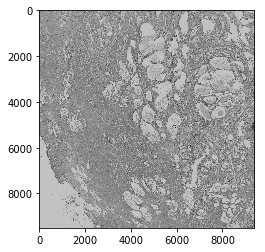

In [11]:
#--IMSHOW
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(mask, cmap='gray')

matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(image, cmap='gray')

print('Degrees = [' + '0'                             + ', ' +
                      str(math.degrees(numpy.pi/4))   + ', ' +
                      str(math.degrees(numpy.pi/2))   + ', ' +
                      str(math.degrees(3*numpy.pi/4)) + ']')

print('Distances: ' + str(distances))

print('Levels: ' + str(levels))

In [12]:
#-------------------------
#    Start Processing
#-------------------------

if (tileWidth != 0 and tileHeight != 0):
    maskTiles, mskRect = splitIMGbySize(tileWidth, tileHeight, maskPath)
    imgTiles, imgRect = splitIMGbySize(tileWidth, tileHeight, imgPath)
else:
    maskTiles, mskRect = splitIMG(tiles, maskPath)
    imgTiles, imgRect = splitIMG(tiles, imgPath)


images = []
masks = []
myTitles = []
i = 0
positions = []    

#RESULT LISTS
imgProp = []
mskProp = []
mskPropInvalid = []
   
for t in range(len(imgTiles)):
    isMask = False
    #-- <Used to plot> --
    masks.append(numpy.array(maskTiles[t]))
    images.append(numpy.array(imgTiles[t]))
    #-- </Used to plot> --
    
    myTitles.append('')

    #-- <GLCM> --
    #result = skimage.feature.greycomatrix(image, distances, fixedDegrees, levels)
    result = skimage.feature.greycomatrix(numpy.copy(imgTiles[t]), distances, fixedDegrees, levels)
    contrast = skimage.feature.greycoprops(result, 'contrast')
    dissimilarity = skimage.feature.greycoprops(result, 'dissimilarity')
    homogeneity = skimage.feature.greycoprops(result, 'homogeneity')
    ASM = skimage.feature.greycoprops(result, 'ASM')
    energy = skimage.feature.greycoprops(result, 'energy')
    
    
    #-- <Other Features> --
    entropy = []
    entropy.append(skimage.measure.shannon_entropy(result[:, :, 0, 0]))
    entropy.append(skimage.measure.shannon_entropy(result[:, :, 0, 1]))
    entropy.append(skimage.measure.shannon_entropy(result[:, :, 0, 2]))
    entropy.append(skimage.measure.shannon_entropy(result[:, :, 0, 3]))
    
    #-- </Other Features> --
    
    descriptors = numpy.zeros((descriptorsQuantity, len(fixedDegrees)))
    descriptors[0] = contrast
    descriptors[1] = dissimilarity
    descriptors[2] = homogeneity
    descriptors[3] = ASM
    descriptors[4] = energy
    descriptors[5] = entropy
   
    #-- </GLCM> --

    mask = np.zeros([maskTiles[t].size[0], maskTiles[t].size[1]])
    mask.fill(255)
       
    #if the tile has more than insideMask
    if (((np.sum(255-np.array(maskTiles[t])) * 100) / np.sum(mask)) > insideMask):
        isMask = True
        obj = imageProperties(imgTiles[t], isMask, t, contrast, dissimilarity, homogeneity, ASM, energy, descriptors, entropy, mskRect[t])
        mskProp.append(obj)
    else:
        #if not mask
        if(((np.sum(255-np.array(maskTiles[t])) * 100) / np.sum(mask)) < insideMaskBorder):
            obj = imageProperties(imgTiles[t], isMask, t, contrast, dissimilarity, homogeneity, ASM, energy, descriptors, entropy, imgRect[t])
            imgProp.append(obj)
        else:
            obj = imageProperties(imgTiles[t], isMask, t, contrast, dissimilarity, homogeneity, ASM, energy, descriptors, entropy, mskRect[t])
            mskPropInvalid.append(obj)

In [35]:
#count = 0
#for i in maskTiles:
#    plt.figure(figsize=(5, 3))
#    plt.imshow(np.array(i), cmap="Greys_r")
#    plt.title('GLCM ' + str(count))
#    count += 1    

In [36]:
#count = 0
#for i in mskProp:
#    plt.figure()
#    plt.imshow(np.array(i.value), cmap="Greys_r")
#    plt.title('position ' + str(i.position) + " count " + str(count))
#    count += 1

In [37]:
#count = 0
#for i in imgProp:
#    plt.figure()
#    plt.imshow(np.array(i.value), cmap="Greys_r")
#    plt.title('position ' + str(i.position) + ' count ' + str(count))
#    count += 1

In [13]:
if (printMaskImg):
    mWidth = len(image[0])
    mHeight = len(image)
    spacement = int(mWidth*0.2 / 100)
    spacement = 1 if spacement < 0 else spacement


    fig = plt.figure(figsize=(8, 5))
    plt.imshow(image, cmap='gray')

    plt.vlines(range(1, mWidth, imgProp[0].value.size[0]), 0, mHeight-1, 'white')
    plt.hlines(range(1, mHeight, imgProp[0].value.size[1]), 0, mWidth-1, 'white')


    for msk in mskProp:
        linha = int(msk.position / math.sqrt(tiles))
        yInicio = linha * msk.value.size[1]
        yFim = yInicio - msk.value.size[1]

        yInicio = (linha+1) * msk.value.size[1]
        yFim = yInicio - msk.value.size[1]
        linhaPos = abs(linha*math.sqrt(tiles) - msk.position)
        xInicio = int(linhaPos * msk.value.size[0])
        xFim = int(xInicio + msk.value.size[0])

        matplotlib.pyplot.vlines(range(xInicio, xFim, spacement), yInicio, yFim, 'lime', alpha=0.1)

    for msk in mskPropInvalid:
        linha = int(msk.position / math.sqrt(tiles))
        yInicio = linha * msk.value.size[1]
        yFim = yInicio - msk.value.size[1]

        yInicio = (linha+1) * msk.value.size[1]
        yFim = yInicio - msk.value.size[1]
        linhaPos = abs(linha*math.sqrt(tiles) - msk.position)
        xInicio = int(linhaPos * msk.value.size[0])
        xFim = int(xInicio + msk.value.size[0])

        plt.vlines(range(xInicio, xFim, spacement), yInicio, yFim, 'red', alpha=0.1)    

    plt.savefig(resultPathTiles, bbox_inches='tight', pad_inches=.25)

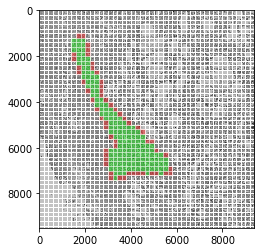

In [14]:
import matplotlib.patches as patches

fig,ax = plt.subplots(1)
ax.imshow(image, cmap='gray')

for a in imgProp:
    rect = patches.Rectangle(a.rectangle,tileWidth,tileHeight,linewidth=1,edgecolor='w',facecolor='none')
    ax.add_patch(rect)

for a in mskProp:
    rect = patches.Rectangle(a.rectangle,tileWidth,tileHeight,linewidth=1,edgecolor='w',facecolor='lime', alpha=0.4)
    ax.add_patch(rect)

for a in mskPropInvalid:
    rect = patches.Rectangle(a.rectangle,tileWidth,tileHeight,linewidth=1,edgecolor='w',facecolor='red', alpha=0.4)
    ax.add_patch(rect)    

plt.savefig(resultPathTiles, bbox_inches='tight', pad_inches=.25)

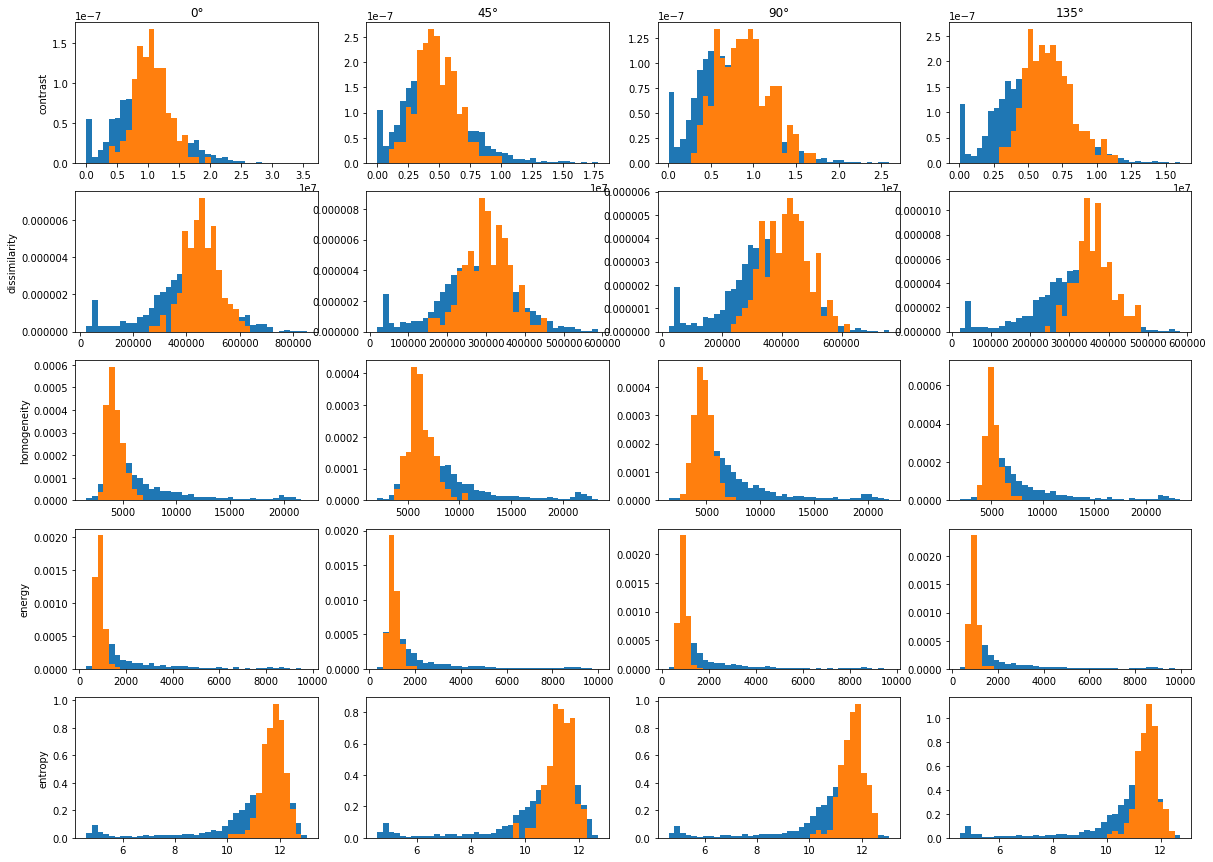

In [15]:
#contrast
featCM0 = []
featCI0 = []
featCM45 = []
featCI45 = []
featCM90 = []
featCI90 = []
featCM135 = []
featCI135 = []

#dissimilarity
featDM0 = []
featDI0 = []
featDM45 = []
featDI45 = []
featDM90 = []
featDI90 = []
featDM135 = []
featDI135 = []

#homogeneity
featHM0 = []
featHI0 = []
featHM45 = []
featHI45 = []
featHM90 = []
featHI90 = []
featHM135 = []
featHI135 = []

#Energy
featENM0 = []
featENI0 = []
featENM45 = []
featENI45 = []
featENM90 = []
featENI90 = []
featENM135 = []
featENI135 = []

#Entropy
featETM0 = []
featETI0 = []
featETM45 = []
featETI45 = []
featETM90 = []
featETI90 = []
featETM135 = []
featETI135 = []


for c in mskProp:
    featCM0.append(c.contrast[0][0])
    featCM45.append(c.contrast[0][1])
    featCM90.append(c.contrast[0][2])
    featCM135.append(c.contrast[0][3])
    
    featDM0.append(c.dissimilarity[0][0])
    featDM45.append(c.dissimilarity[0][1])
    featDM90.append(c.dissimilarity[0][2])
    featDM135.append(c.dissimilarity[0][3])
    
    featHM0.append(c.homogeneity[0][0])
    featHM45.append(c.homogeneity[0][1])
    featHM90.append(c.homogeneity[0][2])
    featHM135.append(c.homogeneity[0][3])
       
    featENM0.append(c.energy[0][0])
    featENM45.append(c.energy[0][1])
    featENM90.append(c.energy[0][2])
    featENM135.append(c.energy[0][3])
    
    featETM0.append(c.entropy[0])
    featETM45.append(c.entropy[1])
    featETM90.append(c.entropy[2])
    featETM135.append(c.entropy[3])
    

for c in imgProp:
    featCI0.append(c.contrast[0][0])
    featCI45.append(c.contrast[0][1])
    featCI90.append(c.contrast[0][2])
    featCI135.append(c.contrast[0][3])
    
    featDI0.append(c.dissimilarity[0][0])
    featDI45.append(c.dissimilarity[0][1])
    featDI90.append(c.dissimilarity[0][2])
    featDI135.append(c.dissimilarity[0][3])
    
    featHI0.append(c.homogeneity[0][0])
    featHI45.append(c.homogeneity[0][1])
    featHI90.append(c.homogeneity[0][2])
    featHI135.append(c.homogeneity[0][3])
       
    featENI0.append(c.energy[0][0])
    featENI45.append(c.energy[0][1])
    featENI90.append(c.energy[0][2])
    featENI135.append(c.energy[0][3])
    
    featETI0.append(0 if c.entropy[0] == float("-inf") else c.entropy[0])
    featETI45.append(0 if c.entropy[1] == float("-inf") else c.entropy[1])
    featETI90.append(0 if c.entropy[2] == float("-inf") else c.entropy[2])
    featETI135.append(0 if c.entropy[3] == float("-inf") else c.entropy[3])
    
    
numBins = 40

fig = plt.figure(figsize=(20,15))
plt.subplot(5, 4, 1)
allValues = list(featCI0) + list(featCM0)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featCI0, bins, normed=True)
plt.hist(featCM0, bins, normed=True)
plt.title('0°')
plt.ylabel("contrast")

plt.subplot(5, 4, 2)
allValues = list(featCI45) + list(featCM45)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featCI45, bins, normed=True)
plt.hist(featCM45, bins, normed=True)
plt.title('45°')

plt.subplot(5, 4, 3)
allValues = list(featCI90) + list(featCM90)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featCI90, bins, normed=True)
plt.hist(featCM90, bins, normed=True)
plt.title('90°')

plt.subplot(5, 4, 4)
allValues = list(featCI135) + list(featCM135)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featCI135, bins, normed=True)
plt.hist(featCM135, bins, normed=True)
plt.title('135°')



plt.subplot(5, 4, 5)
allValues = list(featDI0) + list(featDM0)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featDI0, bins, normed=True)
plt.hist(featDM0, bins, normed=True)
plt.ylabel("dissimilarity")

plt.subplot(5, 4, 6)
allValues = list(featDI45) + list(featDM45)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featDI45, bins, normed=True)
plt.hist(featDM45, bins, normed=True)

plt.subplot(5, 4, 7)
allValues = list(featDI90) + list(featDM90)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featDI90, bins, normed=True)
plt.hist(featDM90, bins, normed=True)

plt.subplot(5, 4, 8)
allValues = list(featDI135) + list(featDM135)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featDI135, bins, normed=True)
plt.hist(featDM135, bins, normed=True)




plt.subplot(5, 4, 9)
allValues = list(featHI0) + list(featHM0)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featHI0, bins, normed=True)
plt.hist(featHM0, bins, normed=True)
plt.ylabel("homogeneity")

plt.subplot(5, 4, 10)
allValues = list(featHI45) + list(featHM45)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featHI45, bins, normed=True)
plt.hist(featHM45, bins, normed=True)

plt.subplot(5, 4, 11)
allValues = list(featHI90) + list(featHM90)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featHI90, bins, normed=True)
plt.hist(featHM90, bins, normed=True)

plt.subplot(5, 4, 12)
allValues = list(featHI135) + list(featHM135)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featHI135, bins, normed=True)
plt.hist(featHM135, bins, normed=True)




plt.subplot(5, 4, 13)
allValues = list(featENI0) + list(featENM0)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featENI0, bins, normed=True)
plt.hist(featENM0, bins, normed=True)
plt.ylabel("energy")

plt.subplot(5, 4, 14)
allValues = list(featENI45) + list(featENM45)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featENI45, bins, normed=True)
plt.hist(featENM45, bins, normed=True)

plt.subplot(5, 4, 15)
allValues = list(featENI90) + list(featENM90)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featENI90, bins, normed=True)
plt.hist(featENM90, bins, normed=True)

plt.subplot(5, 4, 16)
allValues = list(featENI135) + list(featENM135)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featENI135, bins, normed=True)
plt.hist(featENM135, bins, normed=True)




plt.subplot(5, 4, 17)
allValues = list(featETI0) + list(featETM0)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featETI0, bins, normed=True)
plt.hist(featETM0, bins, normed=True)
plt.ylabel("entropy")

plt.subplot(5, 4, 18)
allValues = list(featETI45) + list(featETM45)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featETI45, bins, normed=True)
plt.hist(featETM45, bins, normed=True)

plt.subplot(5, 4, 19)
allValues = list(featETI90) + list(featETM90)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featETI90, bins, normed=True)
plt.hist(featETM90, bins, normed=True)

plt.subplot(5, 4, 20)
allValues = list(featETI135) + list(featETM135)
bins = np.linspace(min(allValues), max(allValues), numBins)
plt.hist(featETI135, bins, normed=True)
plt.hist(featETM135, bins, normed=True)

plt.savefig(resultPathHistogram, bbox_inches='tight', pad_inches=.25)

In [21]:
data = []

for a in imgProp:
    data.append(np.concatenate((a.contrast[0],
                            a.dissimilarity[0], 
                            a.homogeneity[0], 
                            a.energy[0], 
                            a.entropy), axis=0 ))

In [26]:
for a in mskProp:
    data.append(np.concatenate((a.contrast[0],
                                a.dissimilarity[0], 
                                a.homogeneity[0], 
                                a.energy[0], 
                                a.entropy), axis=0 ))

In [23]:
import scipy.stats
std_data = scipy.stats.zscore(data)

PCAdata, eigenvalues, main_eigenvectors = PCA(std_data, 2, False)


In [24]:
colors = ['navy', 'turquoise', 'darkorange', 'green']
target_names = ['Energy', 'Homogeneity', 'Entropy']
lw = 2

colors = ['blue']*len(imgProp) + ['red']*len(mskProp)

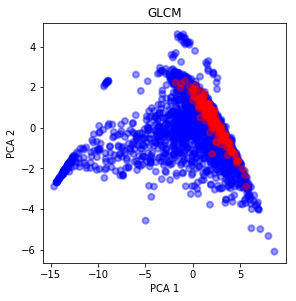

In [25]:
plt.figure()
fig = plt.figure(figsize=(20,15))
plt.subplot(3, 4, 1)
plt.scatter(PCAdata[:, 0], PCAdata[:, 1], color=colors, alpha=.4, lw=lw)
plt.title('GLCM')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.savefig(resultPathPCA, bbox_inches='tight', pad_inches=.25)

In [72]:
idx = numpy.arange(len(imgProp))
numpy.random.shuffle(idx)
idx = idx[:len(mskProp)]
#a = np.sort(a)
print(*idx)
len(np.array(imgProp)[idx])

1956 667 705 415 724 494 96 961 1465 22 1873 1891 430 1050 38 1930 1300 1588 425 314 138 663 1668 572 1020 2019 1159 868 163 1616 820 1108 1515 811 1128 1780 1608 817 551 1775 622 597 341 1401 814 1844 1545 1356 594 356 1812 1811 134 750 2027 566 894 1806 1977 464 48 600 1011 1168 1627 1623 310 127 1745 1848 191 419 1160 900 208 1849 1757 640 629 729 312 104 1438 179 1036 715 1590 1736 1040 931 2025 841 829 1587 448 998 1261 652 1239 1615 735 1519 153 1591 1983 1876 1822 445 225 426 393 1254 1626 1734 355 113 1071 1313 1924 1253 1676 987 587 212 115 1194 467 797 35 1719 1524 74 1655 634 1277 959 1443 1770 7 1452 1265 349 1768 1143 626 288 1884 140 556 2006 1766 1002 1926 1957 1060 1593 1275


157

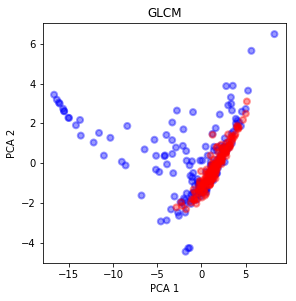

In [74]:
data = []

for a in np.array(imgProp)[idx]:
    data.append(np.concatenate((a.contrast[0],
                                a.dissimilarity[0], 
                                a.homogeneity[0], 
                                a.energy[0], 
                                a.entropy), axis=0 ))

for a in mskProp:
    data.append(np.concatenate((a.contrast[0],
                                a.dissimilarity[0], 
                                a.homogeneity[0], 
                                a.energy[0], 
                                a.entropy), axis=0 ))

colors = ['blue']*len(np.array(imgProp)[idx]) + ['red']*len(mskProp)

std_data = scipy.stats.zscore(data)

PCAdata, eigenvalues, main_eigenvectors = PCA(std_data, 2, False)

plt.figure()
fig = plt.figure(figsize=(20,15))
plt.subplot(3, 4, 1)
plt.scatter(PCAdata[:, 0], PCAdata[:, 1], color=colors, alpha=.4, lw=lw)
plt.title('GLCM')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.savefig(resultPathPCA, bbox_inches='tight', pad_inches=.25)